# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

why log regression as bad as baseline
Present well with labelled plots and an insightful explanation and you'll bag 100.

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [105]:
from __future__ import print_function, division
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from numpy import unravel_index
from sklearn.pipeline import make_pipeline
%matplotlib inline

## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [106]:
data_path = os.path.join(os.getcwd(), 'datasets')


train_A = pd.read_csv(data_path + '/train_images_partA.csv')
valid_A = pd.read_csv(data_path + '/valid_images_partA.csv')

print('Number of data points in train_A: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))
print('Number of data point in valid_A: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))

Number of data points in train_A: 2093, number of attributes: 520
Number of data point in valid_A: 1113, number of attributes: 520


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [107]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [108]:
features = train_A.iloc[:,1:501]
features_names = features.columns.tolist()

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [109]:
X_tr = train_A[features_names]
y_tr = train_A['is_person']

print('Shape of training features: {}, shape of training target: {}'.format(X_tr.shape, y_tr.shape))

X_val = valid_A[features_names]
y_val = valid_A['is_person']

print('Shape of validation features: {}, shape of validation target: {}'.format(X_val.shape, y_val.shape))

Shape of training features: (2093, 500), shape of training target: (2093,)
Shape of validation features: (1113, 500), shape of validation target: (1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

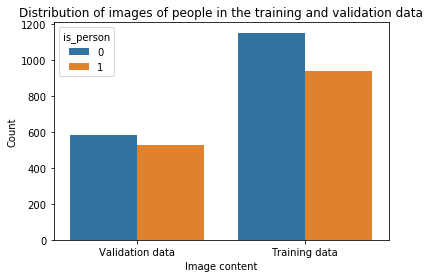

In [110]:
train_A['training_data'] = 1
valid_A['training_data'] = 0

temp = train_A.append(valid_A)


fig = plt.figure(1)
ax = fig.add_subplot(111)
sns.countplot(x = temp['training_data'], hue=temp['is_person'], data=temp)
plt.xlabel('Image content')
plt.ylabel('Count')
ax.set_xticklabels(['Validation data', 'Training data'])
_ = plt.title('Distribution of images of people in the training and validation data')

### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

We want to have a baseline that maximizes the metric of interest (accuracy) with a naive/dummy method. We assume that both classes are equally important so I'm choosing most_frequent strategy - assigning all examples to not a person class - because it will give the highest accuracy.  

In [111]:
dummy = DummyClassifier(strategy = 'most_frequent', constant = 1)
val_accuracy = dummy.fit(X_tr, y_tr).score(X_val, y_val)
train_accuracy = dummy.fit(X_tr, y_tr).score(X_tr, y_tr)
print("Accuracy of the dummy clasifier on the training set: {:.3f}".format(train_accuracy))
print("Accuracy of the dummy clasifier on the validation set: {:.3f}".format(val_accuracy))

Accuracy of the dummy clasifier on the training set: 0.551
Accuracy of the dummy clasifier on the validation set: 0.527


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

Training accuracy: 0.551
Validation accuracy: 0.527


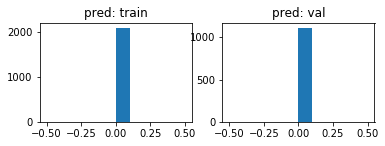

In [112]:
lr = LogisticRegression(solver="lbfgs")
lr.fit(X_tr, y_tr)
print("Training accuracy: {:.3f}".format(lr.score(X_tr, y_tr)))
print("Validation accuracy: {:.3f}".format(lr.score(X_val, y_val)))

plt.subplot(221)
plt.hist(lr.predict(X_tr))
plt.title("pred: train")
plt.subplot(222)
plt.hist(lr.predict(X_val))
_ = plt.title("pred: val")

#print("Coefficients: {}".format(lr.coef_))
#print("Intercept: {}".format(lr.intercept_))

Logistic regression predicts the most frequent class (0) for all the data points, both in the validation and training dataset - it gives the same results as the baseline. Logistic regression predicts probability of the data point being in a given class. If the threshold is set to 0.5 and the probability of data point being in the positive class is lower than 0.5 it assigns the negative label to all the data points.

### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations for each column in your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [113]:
first_5 = train_A.iloc[:,1:6]

print("Mean values: ")
print(first_5.mean(axis = 0))
print("Std values: ")
print(first_5.std(axis = 0))

# the counts are normalized, but they aren't centered around 0

Mean values: 
dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64
Std values: 
dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64


### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [114]:
scaler = StandardScaler()
scaler.fit(X_tr)

trans_X_tr = scaler.transform(X_tr)
trans_X_val = scaler.transform(X_val)

for i in range(0, 5):
    print("Mean of the transformed training dataset for the feature nr {:.3f}: ".format(i+1))
    print(np.mean(trans_X_tr[:, i]))
    print("Std of the transformed training dataset for the feature nr {:.3f}: ".format(i+1))
    print(np.std(trans_X_tr[:, i]))
    print("Mean of the transformed validation dataset for the feature nr {:.3f}: ".format(i+1))
    print(np.mean(trans_X_val[:, i]))
    print("Std of the transformed validation dataset for the feature nr {:.3f}: ".format(i+1))
    print(np.std(trans_X_val[:, i]))

Mean of the transformed training dataset for the feature nr 1.000: 
-3.39485301367e-17
Std of the transformed training dataset for the feature nr 1.000: 
1.0
Mean of the transformed validation dataset for the feature nr 1.000: 
-0.00550612324325
Std of the transformed validation dataset for the feature nr 1.000: 
1.0131088626
Mean of the transformed training dataset for the feature nr 2.000: 
-2.20665445888e-17
Std of the transformed training dataset for the feature nr 2.000: 
1.0
Mean of the transformed validation dataset for the feature nr 2.000: 
-0.0382933020105
Std of the transformed validation dataset for the feature nr 2.000: 
0.969819492563
Mean of the transformed training dataset for the feature nr 3.000: 
2.44429416984e-16
Std of the transformed training dataset for the feature nr 3.000: 
1.0
Mean of the transformed validation dataset for the feature nr 3.000: 
0.109150976593
Std of the transformed validation dataset for the feature nr 3.000: 
1.04922849828
Mean of the transf

As expected, standard deviation of the training dataset is constant and equal to 1 and the mean value is close to 0.0. The validation set was transformed too and the distribution of each individual feature in the set is close to standard normal distribution, which is what we wanted. We want to compute the mean and standard deviation on a training set and re-apply the same transformation on the validation set. It doesn't make sense to use the statistics of validation/testing set (that should represent the unseen data) in the training phase, including the variables scaling. But we make the assumption that the unseen data has roughly the same distribution as the data model was trained on so we use the same scaler for both training and validation set.

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

Training accuracy: 0.811
Validation accuracy: 0.643
Precision: 0.596
Recall: 0.631


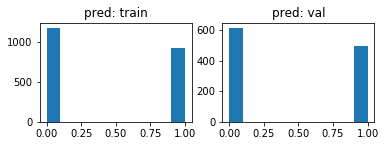

In [115]:
lr = LogisticRegression(solver="lbfgs")
lr.fit(trans_X_tr, y_tr)
print("Training accuracy: {:.3f}".format(lr.score(trans_X_tr, y_tr)))
print("Validation accuracy: {:.3f}".format(lr.score(trans_X_val, y_val)))

plt.subplot(221)
plt.hist(lr.predict(trans_X_tr))
plt.title("pred: train")
plt.subplot(222)
plt.hist(lr.predict(trans_X_val))
_ = plt.title("pred: val")

print("Precision: {:.3f}".format(precision_score(lr.predict(trans_X_val), y_val)))
print("Recall: {:.3f}".format(recall_score(lr.predict(trans_X_val), y_val)))

#print("Coefficients: {}".format(lr.coef_))
#print("Intercept: {}".format(lr.intercept_))

The model trained on features centered at 0 and with a unit standard deviation learned to predict both classes with a rather high accuracy. The coefficients are now more interpretable.  

### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [116]:
kf = KFold(n_splits=3, shuffle = True, random_state = 0)

for train_index, test_index in kf.split(trans_X_tr):
    print(trans_X_tr[test_index].shape[0])

698
698
697


### ========== Question 1.12 --- [2 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [117]:
scores = np.zeros([3, 20])

C_range = np.logspace(-5, 5, 20)

for i, (train_index, test_index) in enumerate(kf.split(trans_X_tr)):
    for j, C in enumerate(C_range, 0):
        #print (C)
        lr = LogisticRegression(solver="lbfgs", C=C)
        lr.fit(trans_X_tr[train_index], y_tr[train_index])
        scores[i][j] = lr.score(trans_X_tr[test_index], y_tr[test_index])

In [118]:
scores

array([[ 0.5730659 ,  0.62893983,  0.66762178,  0.67191977,  0.68767908,
         0.69627507,  0.6747851 ,  0.67048711,  0.65329513,  0.65902579,
         0.65902579,  0.65329513,  0.64899713,  0.64613181,  0.64613181,
         0.64899713,  0.64613181,  0.64613181,  0.64899713,  0.64899713],
       [ 0.54584527,  0.63180516,  0.69484241,  0.71919771,  0.72922636,
         0.73495702,  0.70200573,  0.6747851 ,  0.65472779,  0.63610315,
         0.63180516,  0.63323782,  0.6260745 ,  0.62750716,  0.62750716,
         0.6260745 ,  0.6260745 ,  0.6260745 ,  0.62750716,  0.6260745 ],
       [ 0.54806313,  0.63558106,  0.64275466,  0.65566714,  0.68005739,
         0.70014347,  0.68149211,  0.67001435,  0.66284075,  0.64418938,
         0.63271162,  0.62553802,  0.6241033 ,  0.6241033 ,  0.6241033 ,
         0.6241033 ,  0.6241033 ,  0.6241033 ,  0.6241033 ,  0.6241033 ]])

### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

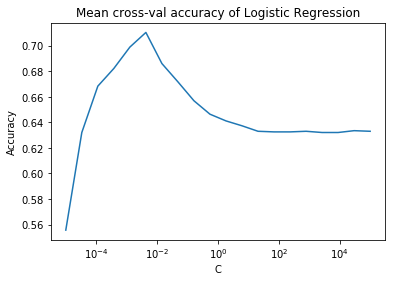

In [119]:
mean_scores = np.mean(scores, axis=0)
plt.plot(C_range, mean_scores)
plt.xscale('log') 
plt.xlabel('C')
plt.ylabel('Accuracy')
_ = plt.title('Mean cross-val accuracy of Logistic Regression')

### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [120]:
C_optimal = C_range[np.argmax(mean_scores)]
print("Maximum mean accuracy: {:.3f} for the C equal to: {:.3f}".format(np.max(mean_scores), C_optimal))

lr = LogisticRegression(solver="lbfgs", C=C_optimal)
lr.fit(trans_X_tr, y_tr)
print("Validation accuracy: {:.3f}".format(lr.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(lr.score(trans_X_tr, y_tr)))

Maximum mean accuracy: 0.710 for the C equal to: 0.004
Validation accuracy: 0.696
Training accuracy: 0.780


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [121]:
lr_cv = LogisticRegressionCV(Cs=C_range, cv=kf, solver='lbfgs', random_state=0)
lr_cv.fit(trans_X_tr, y_tr)

print("The optimal value for parameter C: {}".format(lr_cv.C_))
print("Validation accuracy: {:.3f}".format(lr_cv.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(lr_cv.score(trans_X_tr, y_tr)))

The optimal value for parameter C: [ 0.00428133]
Validation accuracy: 0.696
Training accuracy: 0.780


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to the labs if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [122]:
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(trans_X_tr, y_tr)
print("Validation accuracy: {:.3f}".format(clf.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(clf.score(trans_X_tr, y_tr)))

Validation accuracy: 0.693
Training accuracy: 1.000


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

The model has overfitted - it fits the training data perfectly but the validation accuracy is significantly lower than the training accuracy, and lower than for the tuned logistic regression. We only have around 2000 datapoints in training - and 500 trees x no max depth => loots of parameters to fit. The number of estimators is the same as the number of features and they can grow to full depth so they have learned to separate the training data perfectly. 

### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [123]:
feature_importance = clf.feature_importances_
for i in feature_importance.argsort()[-50:][::-1]:
    print('Feature {} with the importance of: {:.3f}'.format(X_tr.columns[i], feature_importance[i]))

Feature dim21 with the importance of: 0.008
Feature dim51 with the importance of: 0.008
Feature dim360 with the importance of: 0.007
Feature dim4 with the importance of: 0.006
Feature dim479 with the importance of: 0.006
Feature dim76 with the importance of: 0.006
Feature dim283 with the importance of: 0.006
Feature dim461 with the importance of: 0.006
Feature dim343 with the importance of: 0.005
Feature dim398 with the importance of: 0.005
Feature dim348 with the importance of: 0.005
Feature dim74 with the importance of: 0.005
Feature dim485 with the importance of: 0.005
Feature dim356 with the importance of: 0.005
Feature dim330 with the importance of: 0.005
Feature dim217 with the importance of: 0.005
Feature dim263 with the importance of: 0.005
Feature dim222 with the importance of: 0.004
Feature dim134 with the importance of: 0.004
Feature dim500 with the importance of: 0.004
Feature dim274 with the importance of: 0.004
Feature dim254 with the importance of: 0.004
Feature dim206 w

### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [124]:
def report(model, kernel='linear'):
    print("Training accuracy of the model with {} kernel: {:.3f}".format(kernel, model.score(trans_X_tr, y_tr)))
    print("Validation accuracy of the model with {} kernel: {:.3f}".format(kernel, model.score(trans_X_val, y_val)))
    

svc_linear = LinearSVC()
svc_rbf = SVC(kernel='rbf')
svc_poly = SVC(kernel='poly')

svc_linear.fit(trans_X_tr, y_tr)
report(svc_linear)
svc_rbf.fit(trans_X_tr, y_tr)
report(svc_rbf, kernel = 'rbf')
svc_poly.fit(trans_X_tr, y_tr)
report(svc_poly, kernel = 'polynomial')

Training accuracy of the model with linear kernel: 0.807
Validation accuracy of the model with linear kernel: 0.639
Training accuracy of the model with rbf kernel: 0.911
Validation accuracy of the model with rbf kernel: 0.730
Training accuracy of the model with polynomial kernel: 0.991
Validation accuracy of the model with polynomial kernel: 0.702


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [125]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

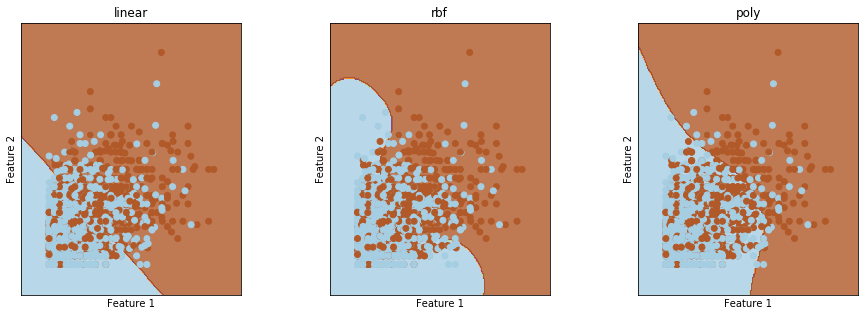

In [126]:
X_2d = trans_X_tr[:, [20, 75]]

svc_linear = LinearSVC()
svc_rbf = SVC(kernel='rbf')
svc_poly = SVC(kernel='poly')


svc_linear.fit(X_2d, y_tr)
svc_rbf.fit(X_2d, y_tr)
svc_poly.fit(X_2d, y_tr)


svms = [svc_linear, svc_rbf, svc_poly]

show_svc_decision_boundaries(svms, X_2d, ['linear', 'rbf', 'poly'])

The input data clearly isn't linearly separable. Rbf and polynomial kernels produce more flexible decision boundaries but they won't give high accuracy either. These two features aren't enough to draw accurate decision boundaries. 

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [127]:
scores = np.zeros([3, 10])

C_range = np.logspace(-2, 3, 10)

for i, (train_index, test_index) in enumerate(kf.split(trans_X_tr), 0):
    for j, C in enumerate(C_range, 0):
        #print (C)
        svc_rbf = SVC(kernel='rbf', C=C)
        svc_rbf.fit(trans_X_tr[train_index], y_tr[train_index])
        scores[i][j] = svc_rbf.score(trans_X_tr[test_index], y_tr[test_index])

In [128]:
scores

array([[ 0.56017192,  0.58309456,  0.67191977,  0.70200573,  0.71346705,
         0.70916905,  0.70916905,  0.70916905,  0.70916905,  0.70916905],
       [ 0.54584527,  0.54584527,  0.69770774,  0.73782235,  0.73925501,
         0.71346705,  0.71346705,  0.71346705,  0.71346705,  0.71346705],
       [ 0.54662841,  0.54806313,  0.68579627,  0.69727403,  0.69296987,
         0.68292683,  0.68292683,  0.68292683,  0.68292683,  0.68292683]])

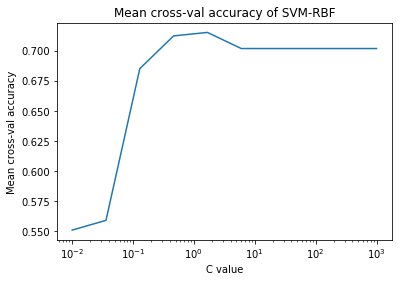

In [129]:
mean_scores = np.mean(scores, axis=0)
plt.plot(C_range, mean_scores)
plt.xscale('log') #?
plt.xlabel('C value')
plt.ylabel('Mean cross-val accuracy')
_ = plt.title('Mean cross-val accuracy of SVM-RBF')

In [130]:
C_optimal = C_range[np.argmax(mean_scores)]
print("Maximum mean accuracy: {:.3f} for the C equal to: {:.3f}".format(np.max(mean_scores), C_optimal))

svc_rbf = SVC(kernel='rbf', C=C_optimal)
svc_rbf.fit(trans_X_tr, y_tr)

print("Validation accuracy: {:.3f}".format(svc_rbf.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(svc_rbf.score(trans_X_tr, y_tr)))

Maximum mean accuracy: 0.715 for the C equal to: 1.668
Validation accuracy: 0.728
Training accuracy: 0.975


### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [131]:
scores = np.zeros([3, 10])

gamma_range = np.logspace(-5, 0, 10)

for i, (train_index, test_index) in enumerate(kf.split(trans_X_tr), 0):
    for j, gamma in enumerate(gamma_range, 0):
        svc_rbf = SVC(kernel='rbf', C=1.0, gamma=gamma)
        svc_rbf.fit(trans_X_tr[train_index], y_tr[train_index])
        scores[i][j] = svc_rbf.score(trans_X_tr[test_index], y_tr[test_index])

In [132]:
scores

array([[ 0.56160458,  0.66189112,  0.67191977,  0.70487106,  0.71346705,
         0.71060172,  0.56017192,  0.56017192,  0.56017192,  0.56017192],
       [ 0.54584527,  0.65902579,  0.71060172,  0.74498567,  0.74212034,
         0.7234957 ,  0.54584527,  0.54584527,  0.54584527,  0.54584527],
       [ 0.54662841,  0.64418938,  0.65710187,  0.68149211,  0.69296987,
         0.68292683,  0.54662841,  0.54662841,  0.54662841,  0.54662841]])

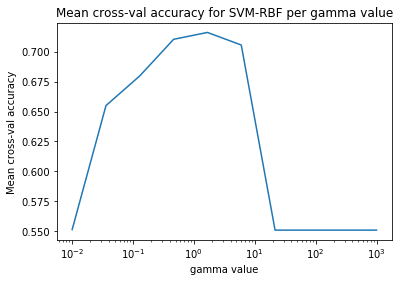

In [133]:
mean_scores = np.mean(scores, axis=0)
plt.plot(C_range, mean_scores)
plt.xscale('log') 
plt.xlabel('gamma value')
plt.ylabel('Mean cross-val accuracy')
_ = plt.title('Mean cross-val accuracy for SVM-RBF per gamma value')

In [134]:
gamma_optimal = gamma_range[np.argmax(mean_scores)]
print("Maximum mean accuracy: {:.3f} for the gamma equal to: {:.3f}".format(np.max(mean_scores), gamma_optimal))

svc_rbf = SVC(kernel='rbf', C=1.0, gamma=gamma_optimal)
svc_rbf.fit(trans_X_tr, y_tr)

print("Validation accuracy: {:.3f}".format(svc_rbf.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(svc_rbf.score(trans_X_tr, y_tr)))

Maximum mean accuracy: 0.716 for the gamma equal to: 0.002
Validation accuracy: 0.727
Training accuracy: 0.891


### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [135]:
scores = np.zeros([3, 4, 4])

C_range = np.logspace(-2, 1, 4)
gamma_range = np.logspace(-4, -1, 4)


for i, (train_index, test_index) in enumerate(kf.split(trans_X_tr), 0):
    for j, C in enumerate(C_range, 0):
        for k, gamma in enumerate(gamma_range, 0):
            svc_rbf = SVC(kernel='rbf', C=C, gamma=gamma)
            svc_rbf.fit(trans_X_tr[train_index], y_tr[train_index])
            scores[i][j][k] = svc_rbf.score(trans_X_tr[test_index], y_tr[test_index])

In [136]:
scores

array([[[ 0.56017192,  0.56017192,  0.56017192,  0.56017192],
        [ 0.56017192,  0.67621777,  0.56017192,  0.56017192],
        [ 0.67335244,  0.70773639,  0.65759312,  0.56017192],
        [ 0.6991404 ,  0.69197708,  0.67048711,  0.56017192]],

       [[ 0.54584527,  0.54584527,  0.54584527,  0.54584527],
        [ 0.54584527,  0.69627507,  0.54584527,  0.54584527],
        [ 0.70773639,  0.74212034,  0.64899713,  0.54584527],
        [ 0.73782235,  0.6991404 ,  0.67908309,  0.54584527]],

       [[ 0.54662841,  0.54662841,  0.54662841,  0.54662841],
        [ 0.54662841,  0.67718795,  0.54662841,  0.54662841],
        [ 0.66284075,  0.68723099,  0.6312769 ,  0.54662841],
        [ 0.69296987,  0.68149211,  0.64131994,  0.54662841]]])

In [137]:
mean_scores = np.mean(scores, axis=0)
mean_scores

array([[ 0.55088187,  0.55088187,  0.55088187,  0.55088187],
       [ 0.55088187,  0.68322693,  0.55088187,  0.55088187],
       [ 0.68130986,  0.71236257,  0.64595572,  0.55088187],
       [ 0.70997754,  0.69086986,  0.66363005,  0.55088187]])

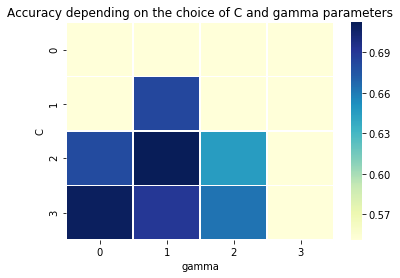

In [138]:
sns.heatmap(mean_scores, cmap="YlGnBu", linewidths=.5)
plt.title("Accuracy depending on the choice of C and gamma parameters")
plt.ylabel("C")
_ = plt.xlabel("gamma") 

In [139]:
C_optimal_ind = np.where(mean_scores == mean_scores.max())[0][0]
C_optimal = C_range[C_optimal_ind]
gamma_optimal_ind = np.where(mean_scores == mean_scores.max())[1][0]
gamma_optimal = gamma_range[gamma_optimal_ind]


print("Maximum mean accuracy: {:.3f} for the C equal to: {:.3f} and gamma equal to: {:.3f}".format(np.max(mean_scores), C_optimal, gamma_optimal))


svc_rbf = SVC(kernel='rbf', C=C_optimal, gamma=gamma_optimal)
svc_rbf.fit(trans_X_tr, y_tr)

print("Validation accuracy: {:.3f}".format(svc_rbf.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(svc_rbf.score(trans_X_tr, y_tr)))

Maximum mean accuracy: 0.712 for the C equal to: 1.000 and gamma equal to: 0.001
Validation accuracy: 0.721
Training accuracy: 0.835


### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

The classification accuracy on the the validation set is lower than in 1.21 (C optimization) and the same as in 1.22 (gamma optimization), possibly because we explored a smaller range of C and gamma values. The improvement would be to perform a grid search on a larger range, eg by using the grid from "A Practial Guide to Support Vector Classification". This comes at the computational cost. 

### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [140]:
scores = np.zeros([3, 7])

degree_range = np.arange(1,8)

for i, (train_index, test_index) in enumerate(kf.split(trans_X_tr), 0):
    for j, degree in enumerate(degree_range, 0):
        svc_poly = SVC(kernel='poly', degree=degree)
        svc_poly.fit(trans_X_tr[train_index], y_tr[train_index])
        scores[i][j] = svc_poly.score(trans_X_tr[test_index], y_tr[test_index])

In [141]:
scores

array([[ 0.67908309,  0.6747851 ,  0.65472779,  0.61318052,  0.63180516,
         0.58309456,  0.55730659],
       [ 0.74498567,  0.67908309,  0.71060172,  0.60888252,  0.58309456,
         0.56017192,  0.55444126],
       [ 0.68436155,  0.64131994,  0.68723099,  0.66140603,  0.60114778,
         0.57962697,  0.57245337]])

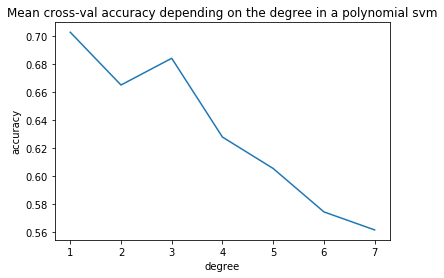

In [142]:
mean_scores = np.mean(scores, axis=0)
plt.plot(degree_range, mean_scores)
plt.title('Mean cross-val accuracy depending on the degree in a polynomial svm')
plt.xlabel('degree')
_ = plt.ylabel('accuracy')

In [143]:
degree_optimal = np.argmax(mean_scores) + 1
print("Maximum mean accuracy: {:.3f} for the degree equal to: {}".format(np.max(mean_scores), degree_optimal))

svc_poly = SVC(kernel='poly', degree=degree_optimal)
svc_poly.fit(trans_X_tr, y_tr)

print("Validation accuracy: {:.3f}".format(svc_poly.score(trans_X_val, y_val)))
print("Training accuracy: {:.3f}".format(svc_poly.score(trans_X_tr, y_tr)))

Maximum mean accuracy: 0.703 for the degree equal to: 1
Validation accuracy: 0.689
Training accuracy: 0.784


### ========== Question 1.26 --- [4 marks] ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

Cross-validation reduces the risk of getting an unusual (biased) testing set. Hold-out validation is a less computationally expensive (but also less accurate in minimizing generalization error) aproximation of k-fold. The main goal is to generalize well for the unseen data so I would choose cross-validation even though it takes more time.

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [144]:
train_A = pd.read_csv(data_path + '/train_images_partA.csv')
valid_A = pd.read_csv(data_path + '/valid_images_partA.csv')

X_tr = train_A.drop(['imgId', 'is_person'], axis=1)
y_tr = train_A['is_person']

X_val = valid_A.drop(['imgId', 'is_person'], axis=1)
y_val = valid_A['is_person']

In [145]:
X_tr.iloc[:,500:518]

# features 500-518 are categorical. no scaling

,is_aeroplane,is_bicycle,is_bird,is_boat,is_bottle,is_bus,is_car,is_cat,is_chair,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
scaler = StandardScaler()
scaler.fit(X_tr.iloc[:, 0:500])

X_tr.iloc[:, 0:500] = scaler.transform(X_tr.iloc[:, 0:500])
X_val.iloc[:, 0:500] = scaler.transform(X_val.iloc[:, 0:500])

In [147]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=31) 

# why we were asked to use the entropy criterion? 

clf.fit(X_tr, y_tr)

print("Validation accuracy: {:.3f}".format(clf.score(X_val, y_val)))
print("Training accuracy: {:.3f}".format(clf.score(X_tr, y_tr)))

Validation accuracy: 0.712
Training accuracy: 1.000


In [148]:
feature_importance = clf.feature_importances_

for i in feature_importance.argsort()[-50:][::-1]:
    print('Feature {} with the importance of: {:.3f}'.format(X_tr.columns[i], feature_importance[i]))

Feature is_cat with the importance of: 0.009
Feature is_bird with the importance of: 0.009
Feature dim21 with the importance of: 0.008
Feature dim51 with the importance of: 0.006
Feature dim360 with the importance of: 0.005
Feature dim4 with the importance of: 0.005
Feature dim76 with the importance of: 0.005
Feature dim398 with the importance of: 0.005
Feature dim283 with the importance of: 0.005
Feature dim479 with the importance of: 0.005
Feature dim263 with the importance of: 0.005
Feature dim343 with the importance of: 0.005
Feature dim423 with the importance of: 0.004
Feature dim485 with the importance of: 0.004
Feature dim254 with the importance of: 0.004
Feature dim461 with the importance of: 0.004
Feature dim222 with the importance of: 0.004
Feature dim356 with the importance of: 0.004
Feature dim74 with the importance of: 0.004
Feature dim288 with the importance of: 0.004
Feature dim214 with the importance of: 0.004
Feature dim348 with the importance of: 0.004
Feature dim330 

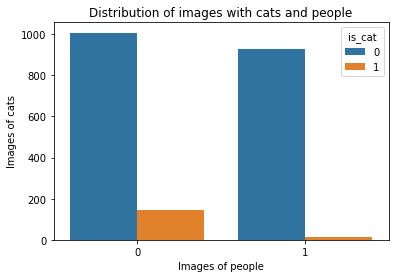

In [149]:
# the 1st strongest feature
sns.countplot(x = train_A['is_person'], hue=train_A['is_cat'], data=train_A)
plt.xlabel('Images of people')
plt.ylabel('Images of cats')
ax.set_xticklabels(['Image without a person', 'Image of a person'])
_ = plt.title('Distribution of images with cats and people')

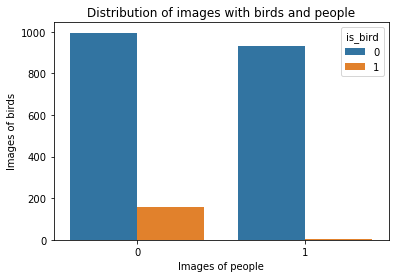

In [150]:
# the 2nd strongest feature 
sns.countplot(x = train_A['is_person'], hue=train_A['is_bird'], data=X_tr)
plt.xlabel('Images of people')
plt.ylabel('Images of birds')
ax.set_xticklabels(['Image without a person', 'Image of a person'])
_ = plt.title('Distribution of images with birds and people')

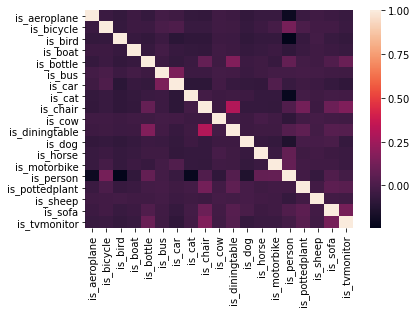

In [151]:
# correlations between categorical features
_ = sns.heatmap(train_A.iloc[:, 501:520].corr())

Two strongest features are binary image labels (is_cat and is_bird), and is_airpline also ended up in the top50, possibly because there is a negative correlation between the presence of these objects and a person in the picture. Validation accuracy is slightly higher than in 1.16, however it's still much lower than the training accuracy and the model is overfitting. We have used entropy criterion instead of the default gini impurity but it doesn't affect the results. Most of the top 50 most important visual word counts are the same in Q1.16 and Q1.27. Model built in Q1.27 would be useful in a scenario where we have access to object detection labels and the only one missing is the "is_person" label. 

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see the labs). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

*Your answer goes here (max. 600 words)*



In [152]:
# Loading the data

train_B = pd.read_csv(data_path + '/train_images_partB.csv')
valid_B = pd.read_csv(data_path + '/valid_images_partB.csv')
test_B = pd.read_csv(data_path + '/test_images_partB.csv')

In [153]:
# Basic statistics 

print('Number of data points in train_B: {}, number of attributes: {}'.format(train_B.shape[0], train_B.shape[1]))
print('Number of data point in valid_B: {}, number of attributes: {}'.format(valid_B.shape[0], valid_B.shape[1]))
print('Number of data point in test_B: {}, number of attributes: {}'.format(test_B.shape[0], test_B.shape[1]))

Number of data points in train_B: 2113, number of attributes: 520
Number of data point in valid_B: 1113, number of attributes: 520
Number of data point in test_B: 1114, number of attributes: 501


In [154]:
# Preprocessing 1: removing the labels and id from the validation and training data, defining the target variable

features = train_B.iloc[:,1:501]
features_names = features.columns.tolist()

X_tr = train_B[features_names]
y_tr = train_B['is_person']

X_val = valid_B[features_names]
y_val = valid_B['is_person']

In [155]:
# Prep 2: scaling

scaler = StandardScaler()
scaler.fit(X_tr)

X_tr_trans = scaler.transform(X_tr)
X_val_trans = scaler.transform(X_val)

In the first part of the assignment, we did a (partial) hyperparameter optimization of the following models with respect to accuracy metric:

- logistic regression 
- SVM with polynomial kernel
- SVM with RBF kernel

So far, we have used Random Forest with fixed parameters and mostly to see feature importance. 
As the first step in the challenge, I'm going to train these models on the new training data with default parameters - we are given the validation set so I'm not going to use k-fold - and check the logloss on validation set. Next, based on the results I will explore the best models and see how the results can be improved with different feature engineering techniques. 

In [156]:
lr = LogisticRegression(solver='lbfgs')
svm_poly = SVC(kernel='poly', probability=True)
svm_rbf = SVC(kernel='rbf', probability=True)
rf = RandomForestClassifier(n_estimators=100)
xgb = GradientBoostingClassifier(n_estimators=100)
# mlp = MLPClassifier()

lr.fit(X_tr_trans, y_tr)
svm_poly.fit(X_tr_trans, y_tr)
svm_rbf.fit(X_tr_trans, y_tr)
rf.fit(X_tr_trans, y_tr)
xgb.fit(X_tr_trans, y_tr)
# mlp.fit(trans_X_tr, y_tr)

print("Validation log loss for Logistic Regression: {:.3f}".format(log_loss(y_val, lr.predict_proba(X_val_trans))))
print("Validation log loss for SVM with polynomial kernel: {:.3f}".format(log_loss(y_val, svm_poly.predict_proba(X_val_trans))))
print("Validation log loss for SVM with RBF kernel: {:.3f}".format(log_loss(y_val, svm_rbf.predict_proba(X_val_trans))))
print("Validation log loss for Random Forest: {:.3f}".format(log_loss(y_val, rf.predict_proba(X_val_trans))))
print("Validation log loss for Gradient Boosting Classifier: {:.3f}".format(log_loss(y_val, xgb.predict_proba(X_val_trans))))
# print("Validation log loss for Neural Network: {}".format(log_loss(y_val, mlp.predict_proba(trans_X_val))))

Validation log loss for Logistic Regression: 0.663
Validation log loss for SVM with polynomial kernel: 0.693
Validation log loss for SVM with RBF kernel: 0.693
Validation log loss for Random Forest: 0.591
Validation log loss for Gradient Boosting Classifier: 0.573


Unsuprisingly, ensemble method of Gradient Boosting trees gives the best log-loss. The data is highly dimensional, so it's worth trying PCA. We will see how many components are enough to represent the given datset. I will also explore how far we can go with the simplest algoritm (Logistic Regression) as maybe it's not necessary to introduce more advanced models.

14


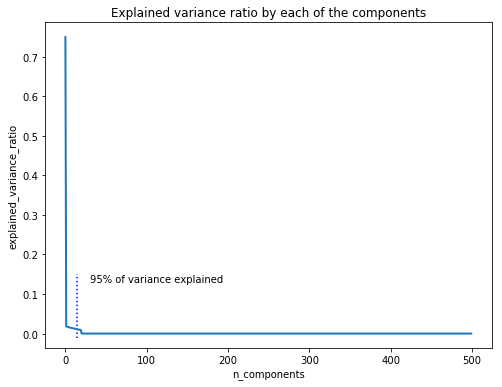

In [157]:
n_components=X_tr_trans.shape[1]
pca = PCA(n_components, random_state=1337)
X_trans = pca.fit_transform(X_tr_trans)


var = 0
for i in range(n_components):
    var = var + pca.explained_variance_ratio_[i]
    # print("Cumulative sum at the component {} is {}".format(i, var)) 
    if var > 0.95:
        print(i)
        break

plt.figure(1, figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')
plt.title("Explained variance ratio by each of the components")

plt.vlines(14, -0.01, 0.15, color='b',linestyles=':')
_= plt.annotate('95% of variance explained', 
             xy=(30, 0.13),  
             xycoords='data')

14 components are enough to represent 95% of the variance. 

In [158]:
n_components=14
pca = PCA(n_components, random_state=1337)
X_trans = pca.fit_transform(X_tr_trans)
X_trans_val = pca.transform(X_val_trans)

xgb = GradientBoostingClassifier(n_estimators=100)
xgb.fit(X_trans, y_tr)
print("Validation log loss for Gradient Boosting Classifier after PCA: {:.3f}".format(log_loss(y_val, xgb.predict_proba(X_trans_val))))
                                                                       
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_trans, y_tr)
print("Validation log loss for SVM-RBF after PCA: {:.3f}".format(log_loss(y_val, svm_rbf.predict_proba(X_trans_val))))

Validation log loss for Gradient Boosting Classifier after PCA: 0.645
Validation log loss for SVM-RBF after PCA: 0.693


In [159]:
scores = np.zeros([20])

C_range = np.logspace(-5, 5, 20)

for j, C in enumerate(C_range, 0):
    lr = LogisticRegression(solver="lbfgs", C=C)
    lr.fit(X_trans, y_tr)
    scores[j] = log_loss(y_val, lr.predict_proba(X_trans_val)) 
    
print("Logistic Regression scores: {}".format(scores))

Logistic Regression scores: [ 0.69297059  0.69294963  0.69293717  0.69292735  0.69292023  0.69291454
  0.69290459  0.69287931  0.69274972  0.69218576  0.69047914  0.68665133
  0.6815059   0.67700463  0.67511731  0.6758701   0.67722039  0.67635765
  0.67636972  0.67629657]


I'm going to try standard feature selection method to see if it's going to improve the results.

In [160]:
anova_filter = SelectKBest(f_classif, k=10)
# chi2 = SelectKBest(chi2, k=30)

xgb = GradientBoostingClassifier(n_estimators=100)
svm_rbf = SVC(kernel='rbf', probability=True)

anova_svm = make_pipeline(anova_filter, svm_rbf)
anova_xgb = make_pipeline(anova_filter, xgb)

anova_svm.fit(X_trans, y_tr)
anova_xgb.fit(X_trans, y_tr)

print("Validation log loss for SVM with RBF kernel and anova filter (k=10): {:.3f}".format(log_loss(y_val, anova_svm.predict_proba(X_trans_val))))
print("Validation log loss for XGB with anova filter (k=10): {:.3f}".format(log_loss(y_val, anova_xgb.predict_proba(X_trans_val))))

# on the full dataset

anova_filter = SelectKBest(f_classif, k=30)
# chi2 = SelectKBest(chi2, k=30)

xgb = GradientBoostingClassifier(n_estimators=100)
svm_rbf = SVC(kernel='rbf', probability=True)

anova_svm = make_pipeline(anova_filter, svm_rbf)
anova_xgb = make_pipeline(anova_filter, xgb)

anova_svm.fit(X_tr_trans, y_tr)
anova_xgb.fit(X_tr_trans, y_tr)

print("Validation log loss for SVM with RBF kernel and anova filter (k=30) without PCA: {:.3f}".format(log_loss(y_val, anova_svm.predict_proba(X_val_trans))))
print("Validation log loss for XGB with anova filter (k=30) without PCA: {:.3f}".format(log_loss(y_val, anova_xgb.predict_proba(X_val_trans))))

Validation log loss for SVM with RBF kernel and anova filter (k=10): 0.693
Validation log loss for XGB with anova filter (k=10): 0.663
Validation log loss for SVM with RBF kernel and anova filter (k=30) without PCA: 0.693
Validation log loss for XGB with anova filter (k=30) without PCA: 0.624


For SVM-RBF we would be interested in optimizing C and gamma for this problems (classes are roughly balanced so I'm leaving the class_weight as None). 

In [161]:
C_range = np.logspace(-2, 1, 4)
gamma_range = np.logspace(-4, -1, 4)

scores = np.zeros([len(C_range), len(gamma_range)])

for i, C in enumerate(C_range):
    for j, gamma in enumerate(gamma_range):
        svc_rbf = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
        svc_rbf.fit(X_trans, y_tr)
        scores[i][j] = log_loss(y_val, svc_rbf.predict_proba(X_trans_val))

In [162]:
scores

array([[ 0.69345915,  0.69317473,  0.69270402,  0.69323482],
       [ 0.69294078,  0.69288138,  0.69288972,  0.6934026 ],
       [ 0.69290762,  0.69291614,  0.69295182,  0.69303108],
       [ 0.69294102,  0.69291847,  0.69303475,  0.6927806 ]])

In [163]:
# the best classifier so far 

xgb = GradientBoostingClassifier(n_estimators=100)
xgb.fit(X_tr, y_tr) # no effect of scaling
print("Validation log loss for Gradient Boosting Classifier: {:.3f}".format(log_loss(y_val, xgb.predict_proba(X_val))))

Validation log loss for Gradient Boosting Classifier: 0.573


In [164]:
feature_importance = xgb.feature_importances_
for i in feature_importance.argsort()[-50:][::-1]:
    print('Feature {} with the importance of: {:.3f}'.format(X_tr.columns[i], feature_importance[i]))

Feature dim38 with the importance of: 0.018
Feature dim51 with the importance of: 0.018
Feature dim500 with the importance of: 0.017
Feature dim485 with the importance of: 0.015
Feature dim222 with the importance of: 0.015
Feature dim254 with the importance of: 0.014
Feature dim330 with the importance of: 0.013
Feature dim160 with the importance of: 0.013
Feature dim21 with the importance of: 0.012
Feature dim423 with the importance of: 0.011
Feature dim294 with the importance of: 0.011
Feature dim137 with the importance of: 0.010
Feature dim35 with the importance of: 0.010
Feature dim323 with the importance of: 0.009
Feature dim263 with the importance of: 0.009
Feature dim161 with the importance of: 0.009
Feature dim417 with the importance of: 0.009
Feature dim188 with the importance of: 0.009
Feature dim405 with the importance of: 0.009
Feature dim264 with the importance of: 0.009
Feature dim360 with the importance of: 0.008
Feature dim443 with the importance of: 0.008
Feature dim416

In [165]:
XB_test = test_B.drop('is_person', axis = 1)
test_images_partB_pred_proba = xgb.predict_proba(XB_test)
test_images_partB_pred_proba

array([[ 0.90839274,  0.09160726],
       [ 0.95288324,  0.04711676],
       [ 0.46650157,  0.53349843],
       ..., 
       [ 0.58674245,  0.41325755],
       [ 0.73612961,  0.26387039],
       [ 0.32575891,  0.67424109]])

In [166]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(test_images_partB_pred_proba) 

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)